In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
sys.path.append('../src/fnc')

import LMPC
import SysModel
from Track import Map
import Utilities
import pwa_cluster as pwac

import matplotlib.pyplot as plt

In [3]:
trackMap = Map(0.8) 
dt = 0.1
n = 6; d = 2
state_names = ['vx', 'vy', 'wz', 'epsi', 's', 'ey']

n_data = 500

In [4]:
def generate_random_input():
    # x = [vx, vy, wz, epsi, s, ey]
    # u = [delta, a]
    x = np.random.uniform(size=[n]) * np.array([3, 1, 1, 1, trackMap.TrackLength, 2*0.8]) + np.array([0, 0, 0, 0, 0, -0.8])
    u = np.random.uniform(size=[d]) * np.array([1, 2]) + np.array([-0.5, -1])
    return x, u

def get_z_y_pair():
    x, u = generate_random_input()
    x_glob = trackMap.get_global_state(x)
    x_next, x_glob_next = SysModel._DynModel(x, x_glob, u, dt, trackMap.PointAndTangent)
    return np.hstack([x,u]), x_next


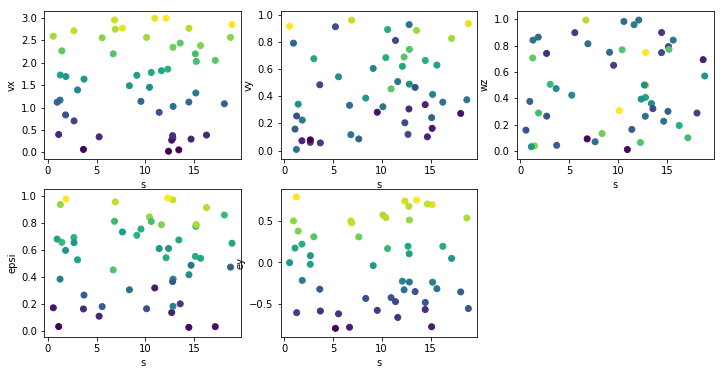

In [5]:
zs = []; ys = []
for i in range(n_data):
    z, y = get_z_y_pair()
    zs.append(z); ys.append(y)

zs = np.array(zs)
ys = np.array(ys)
    
plt.figure(figsize=[12,6])

for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(zs[::10,4], zs[::10,ind], c=[ys[::10,ind]])
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

In [7]:
best_clustering = pwac.ClusterPWA.from_num_clusters(zs, ys, 15)

In [8]:
best_clustering.fit_clusters(verbose=True, z_cutoff=n)

assigning datapoints to clusters
updating models
centroid movement 3.6280970007
assigning datapoints to clusters
updating models
centroid movement 1.08369500339
assigning datapoints to clusters
updating models
centroid movement 0.708846906172
assigning datapoints to clusters
updating models
centroid movement 0.619959651086
assigning datapoints to clusters
updating models
centroid movement 0.498856447624
assigning datapoints to clusters
updating models
centroid movement 0.406931440141
assigning datapoints to clusters
updating models
centroid movement 0.334644659693
assigning datapoints to clusters
updating models
centroid movement 0.285961358002
assigning datapoints to clusters
updating models
centroid movement 0.276500302262
assigning datapoints to clusters
updating models
centroid movement 0.243959933559
assigning datapoints to clusters
updating models
centroid movement 0.261108030485
assigning datapoints to clusters
updating models
centroid movement 0.238700839904
assigning datapoint

In [8]:
nc_list = [1,4,6,10]
best_clustering, ind_perm = pwac.select_nc_cross_validation(nc_list, zs, ys, verbose=True, z_cutoff=n, affine=False)


===================== Fitting model with Nc= 1 ====================
assigning datapoints to clusters
updating models
centroid movement 5.79829317103
assigning datapoints to clusters
updating models
centroid movement 0.0
done
(375, 6) (125, 6)
avg train error: 0.0273206755361
avg test error: 0.0440332055205
===================== Fitting model with Nc= 4 ====================
assigning datapoints to clusters
updating models
centroid movement 3.19765898394
assigning datapoints to clusters
updating models
centroid movement 1.8367619181
assigning datapoints to clusters
updating models
centroid movement 1.49253270836
assigning datapoints to clusters
updating models
centroid movement 0.937857428704
assigning datapoints to clusters
updating models
centroid movement 0.80586186362
assigning datapoints to clusters
updating models
centroid movement 0.720770946207
assigning datapoints to clusters
updating models
centroid movement 0.53913542019
assigning datapoints to clusters
updating models
centroi

In [9]:
best_clustering.Nc

1

In [12]:
pwac.print_PWA_models(pwac.get_PWA_models(best_clustering.thetas, n, d))

[[ 0.98  0.02  0.    0.01 -0.   -0.01   nan  0.23  0.1    nan  0.1 ]
 [ 0.05  0.23 -0.09 -0.02 -0.    0.     nan  0.14  0.01   nan  0.01]
 [ 0.03  0.15  0.25 -0.11  0.    0.04   nan  4.04 -0.02   nan -0.02]
 [ 0.03  0.01  0.07  0.97  0.   -0.01   nan  0.22 -0.     nan -0.  ]
 [ 0.09 -0.02  0.02 -0.07  1.   -0.04   nan -0.    0.     nan  0.  ]
 [ 0.04  0.03 -0.02  0.09 -0.    1.     nan  0.03  0.     nan  0.  ]]


In [7]:
best_clustering.determine_polytopic_regions(verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1120000, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 70105, constraints m = 140000
Cones:	linear vars: 140000
Setup time: 3.78e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.42e+00  1.43e+01  9.92e-01 -4.59e+01  8.33e+01  1.54e-14  2.67e-01 
   100| 1.74e-01  5.68e-01  1.69e-02  1.08e+01  1.12e+01  4.42e-15  9.45e+00 
   200| 7.74e-02  2.16e-01  1.86e-02  5.74e+00  5.98e+00  4.05e-15  1.96e+01 
   300| 6.84e-02  1.30e-01  1.35e-02  5.36e+00  5.

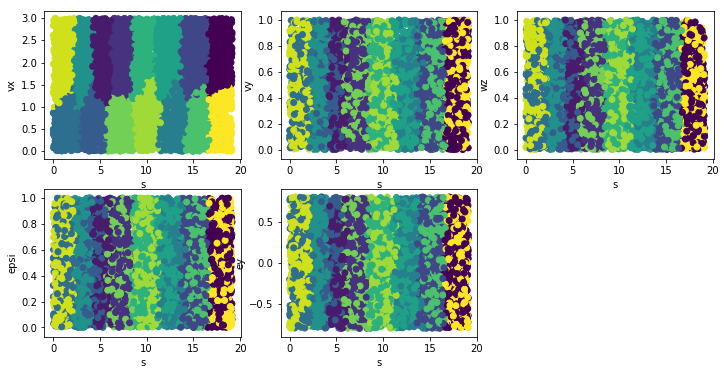

In [10]:
data = np.load('../src/cluster_labels.npz')
data = np.load('pwa_model_15.npz')
# looks like everything is in the same region here....

labels = []
for z,y in zip(zs,ys):
    dot_pdt = [w.T.dot(np.hstack([z[0:n], [1]])) for w in data['region_fns']]
    labels.append(np.argmax(dot_pdt))

plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(zs[:,4], zs[:,ind], c=labels)
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])
# self.clustering = pwac.ClusterPWA.from_labels(zs, ys, 
#                data['labels'], z_cutoff=self.n)
# self.clustering.region_fns = data['region_fns']

In [52]:
data.keys()

['region_fns', 'thetas', 'labels']

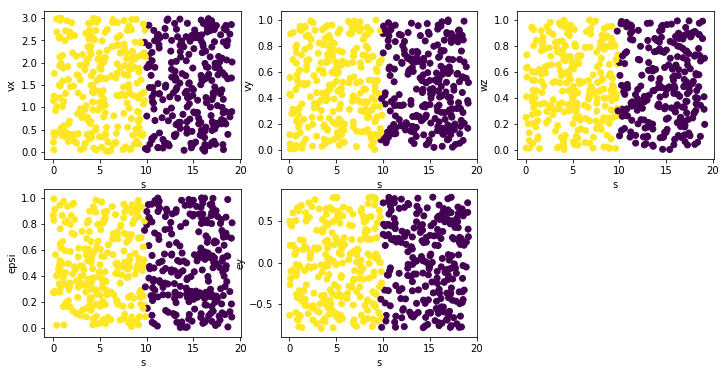

In [48]:
plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(best_clustering.zs[:,4], best_clustering.zs[:,ind], c=best_clustering.cluster_labels)
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

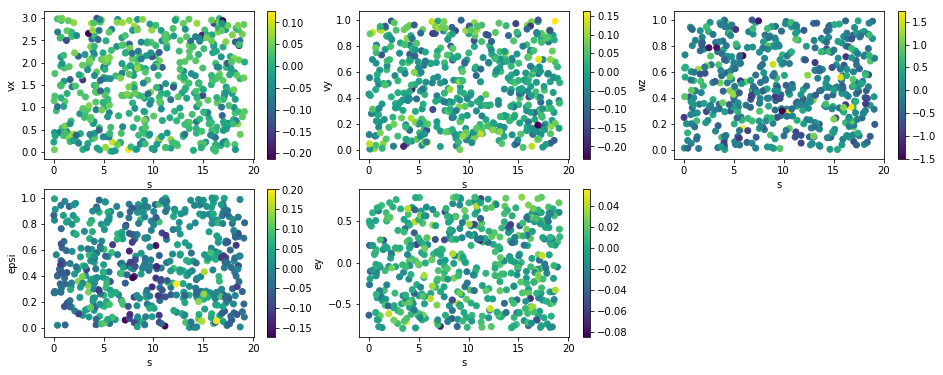

In [49]:
yhats = []
for z,y in zip(best_clustering.zs, best_clustering.ys):
    yhats.append(best_clustering.get_prediction(z))
yhats = np.array(yhats)

plt.figure(figsize=[16,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(best_clustering.zs[:,4], best_clustering.zs[:,ind], c=(best_clustering.ys[:,ind]-yhats[:,ind]))
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind]); plt.colorbar()

In [8]:
# self.clustering = pwac.ClusterPWA.from_labels(zs, ys, 
#                                data['labels'], z_cutoff=self.n)
# self.clustering.region_fns = data['region_fns']
np.savez('pwa_model_'+str(best_clustering.Nc), labels=best_clustering.cluster_labels, region_fns=best_clustering.region_fns, 
         thetas=best_clustering.thetas, zs=best_clustering.zs, ys=best_clustering.ys)

In [9]:
best_clustering.Nc

15

In [8]:
print(x_next)
print(x_glob_next)

[  0.40271081  -0.0565205   -0.51047363   0.06231556  11.55229491
  -0.59633254]
[ 0.40362651 -0.05722567 -0.51032248  3.10423143 -2.42395266 -3.05482882]


In [ ]:
# 10 regions (fit from sim)
[[ 0.99 -0.04 -0.03  0.02  0.    0.03   nan  0.21  0.11   nan -0.  ]
 [ 0.08  0.26 -0.03 -0.05  0.   -0.02   nan  0.24  0.02   nan -0.08]
 [-0.11  0.73 -0.05 -0.28  0.    0.31   nan  2.93  0.13   nan  0.04]
 [ 0.02  0.03  0.02  1.   -0.   -0.03   nan  0.16  0.02   nan  0.  ]
 [ 0.08  0.02 -0.   -0.07  1.   -0.03   nan  0.01 -0.     nan  0.02]
 [ 0.06  0.02 -0.    0.09  0.    0.99   nan  0.03  0.02   nan -0.05]]

In [ ]:
# 2 regions (fit from sim)
[[ 0.98  0.03 -0.01  0.01  0.    0.     nan  0.07  0.1    nan -0.01]
 [ 0.06  0.22 -0.02 -0.03  0.    0.     nan  0.23  0.02   nan -0.05]
 [ 0.05  0.28  0.01 -0.02  0.    0.04   nan  2.73  0.04   nan -0.07]
 [ 0.03  0.01  0.02  1.01  0.   -0.02   nan  0.18  0.     nan  0.  ]
 [ 0.08 -0.    0.   -0.06  1.   -0.03   nan -0.01 -0.     nan  0.02]
 [ 0.05  0.03 -0.    0.08  0.    1.     nan  0.03  0.01   nan -0.04]]
[[ 0.98  0.02 -0.01 -0.   -0.   -0.     nan  0.15  0.1    nan  0.  ]
 [ 0.06  0.24 -0.04 -0.03 -0.    0.01   nan  0.18  0.01   nan -0.05]
 [ 0.07  0.1   0.07  0.07  0.01  0.08   nan  3.32  0.01   nan -0.04]
 [ 0.03  0.01  0.03  1.    0.   -0.02   nan  0.2   0.     nan  0.  ]
 [ 0.09 -0.01  0.01 -0.06  1.   -0.04   nan -0.01  0.     nan  0.02]
 [ 0.05  0.04 -0.    0.08 -0.    1.     nan  0.03  0.     nan -0.04]]


In [ ]:
# 2 (1) regions (fit from trajectory)
[[ 0.95  0.53 -0.05 -0.01 -0.    0.03   nan  0.01  0.09   nan  0.01]
 [-0.01 -0.    0.01 -0.    0.   -0.01   nan  0.25 -0.     nan  0.01]
 [-0.19 -0.94  0.15 -0.02  0.   -0.08   nan  2.41 -0.03   nan  0.12]
 [ 0.02  0.01  0.02  1.09 -0.    0.02   nan  0.18  0.01   nan  0.  ]
 [ 0.09 -0.02  0.   -0.01  1.   -0.02   nan -0.    0.     nan  0.  ]
 [ 0.01 -0.03  0.01  0.07  0.    1.     nan  0.02  0.     nan -0.  ]]
[[ 0.83  0.39 -0.05  0.02 -0.   -0.05   nan  0.04  0.09   nan  0.12]
 [-0.01 -0.12  0.02  0.   -0.   -0.     nan  0.25 -0.     nan  0.01]
 [-0.21 -2.13  0.27  0.03 -0.   -0.04   nan  2.43 -0.     nan  0.14]
 [ 0.01 -0.22  0.05  1.1  -0.    0.01   nan  0.18 -0.     nan  0.01]
 [ 0.08  0.03 -0.   -0.    1.   -0.03   nan  0.    0.     nan  0.01]
 [ 0.    0.01  0.    0.07 -0.    1.     nan  0.02  0.     nan -0.  ]]
